In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

#### Read in Price Data

In [15]:
prices = pd.read_csv("SPY.csv")
prices = prices.rename({'Adj Close': 'price'}, axis=1)
prices = prices[['Date','price']]
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

#### Convert to Log Returns

In [16]:
returns: pd.DataFrame = np.log(prices/prices.shift(1))
returns.dropna(inplace=True)
returns

,price
Date,
2019-07-08,-0.005510
2019-07-09,0.001246
2019-07-10,0.004767
2019-07-11,0.002341
2019-07-12,0.004467
...,...
2024-06-27,0.001575
2024-06-28,-0.003943
2024-07-01,0.002056


#### Temporal train test split

In [17]:
split = int(len(returns) * 0.95)
train = returns.iloc[:split]
test = returns.iloc[split:]

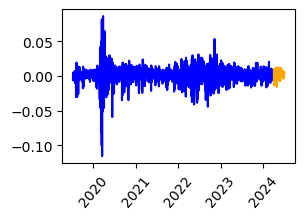

In [18]:
#plot train and test in the same graph with train blue and test orange
plt.figure(figsize=(3,2))
plt.plot(train, color='blue')
plt.plot(test, color='orange')
plt.xticks(rotation=50)
plt.show()

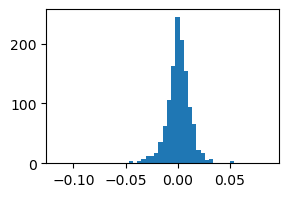

In [19]:
# plot the histogram of the returns
plt.figure(figsize=(3,2))
plt.hist(returns['price'], bins=50)
plt.show()

In [20]:
mu = train.mean()
sigma = train.std()

In [21]:
mu, sigma

(price    0.000527
 dtype: float64,
 price    0.013472
 dtype: float64)

#### LSTM forecasting

In [22]:
import sktime
from sktime.forecasting.neuralforecast import NeuralForecastLSTM
from sktime.forecasting.base import ForecastingHorizon

model = NeuralForecastLSTM(freq='B')
fh = ForecastingHorizon(test.index, is_relative=False, freq='B')
model.fit(train, fh=fh)


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 130 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s, v_num=21, train_loss_step=0.600, train_loss_epoch=0.600]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s, v_num=21, train_loss_step=0.600, train_loss_epoch=0.600]


NeuralForecastLSTM(freq='B')

In [23]:
predictions = model.predict(fh)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]


/opt/miniconda3/envs/finance/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [24]:
predictions

,price
Date,
2024-04-04,0.007321
2024-04-05,0.001386
2024-04-08,-0.000817
2024-04-09,-0.003626
2024-04-10,-0.002980
...,...
2024-06-27,0.004241
2024-06-28,-0.000783
2024-07-01,0.000786


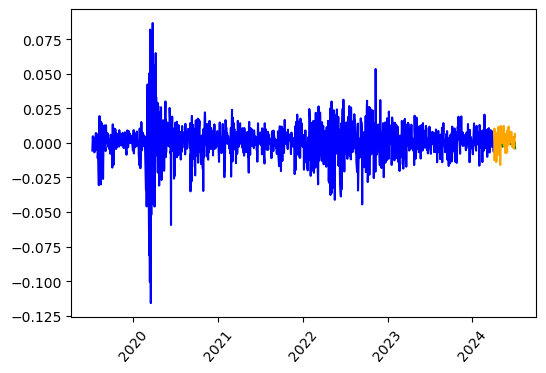

In [25]:
#plot train and predictions in the same graph with train blue and predictions green
plt.figure(figsize=(6,4))
plt.plot(train, color='blue')
plt.plot(predictions, color='green')
plt.plot(test, color='orange')
plt.xticks(rotation=50)
plt.show()


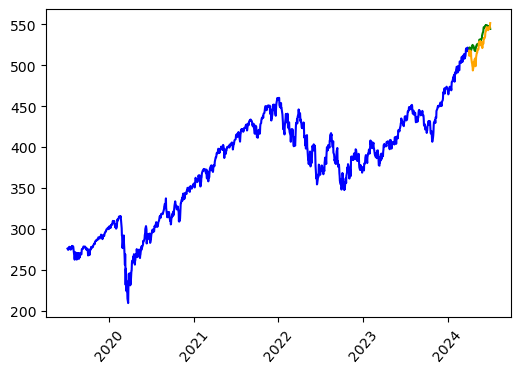

In [26]:
#convert the log returns to prices
# predictions contains the log returns, so we need to convert them to prices, starting with the last price in the training set
last_price = prices.iloc[split-1]['price']
cumulative_returns = predictions.cumsum()
price_predictions = last_price * np.exp(cumulative_returns)
price_predictions = pd.DataFrame(price_predictions, columns=['price'])



#plot the prices of the train set and the predicted prices
plt.figure(figsize=(6,4))
plt.plot(prices.iloc[:split], color='blue')
plt.plot(price_predictions, color='green')
plt.plot(prices.iloc[split:], color='orange')
plt.xticks(rotation=50)
plt.show()


#### Compute metrics
Like MAPE

In [30]:
prices.iloc[split:].shape, price_predictions.shape

((64, 1), (63, 1))

In [31]:
# error metrics
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

mape = MeanAbsolutePercentageError()
mape_error = mape(test, predictions)
print("mape of returns: ", mape_error)

mape_error_price = mape(prices.iloc[split+1:], price_predictions)
print("mape of prices: ", mape_error_price)

mape of returns:  1.5666303502178716
mape of prices:  0.01852137046381777


In [32]:
prices.iloc[split+1:]

,price
Date,
2024-04-04,511.420105
2024-04-05,516.762878
2024-04-08,517.051880
2024-04-09,517.650024
2024-04-10,512.466736
...,...
2024-06-27,546.369995
2024-06-28,544.219971
2024-07-01,545.340027


In [33]:
price_predictions

,price
Date,
2024-04-04,520.971863
2024-04-05,521.694336
2024-04-08,521.268127
2024-04-09,519.381592
2024-04-10,517.835999
...,...
2024-06-27,547.576172
2024-06-28,547.147339
2024-07-01,547.577881


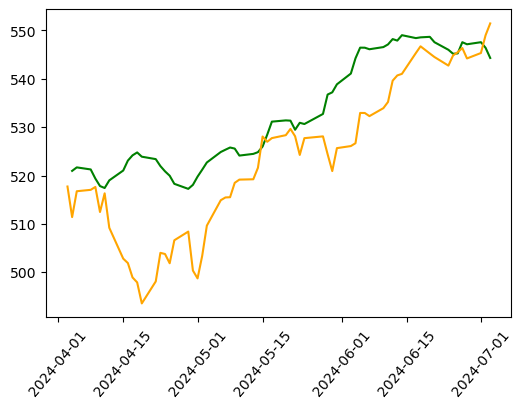

In [34]:
#plot the prices of the train set and the predicted prices
plt.figure(figsize=(6,4))
plt.plot(price_predictions, color='green')
plt.plot(prices.iloc[split:], color='orange')
plt.xticks(rotation=50)
plt.show()